### Import necessary libraries

In [1]:
#Machine Learning
import os
import tensorflow as tf
import keras
from keras import layers
#Maths/Plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

2023-08-03 11:50:22.715097: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-03 11:50:22.755869: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-03 11:50:22.757135: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 11:50:23.489445: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Set the parameters

In [2]:
#Parameters
k_f, k_r, k_cat = [0.71, 0.97], [19, 7000], [6700, 10000]
s0, e, s1, s2 = 5.0, 0.66, 0, 0
val_0 = np.array([s0,s1,s2]) #Start values
k1 = e*((k_f[0]*k_cat[0])/(k_r[0]+k_cat[0]))
k2 = e*((k_f[1]*k_cat[1])/(k_r[1]+k_cat[1]))
pi = k_cat[1]/(k_r[1]+k_cat[1]) #zero-based indexing

print("Parameters: ",k1, k2, pi)
print("Start values: ", val_0)

Parameters:  0.4672748920970383 0.37658823529411767 0.5882352941176471
Start values:  [5. 0. 0.]


### Set up the differential equation function

In [3]:
def f(val):
    mul_ar = np.array([[-k1, 0, 0],
                       [k1*(1-pi), -k2, 0],
                       [k1*pi, k2, 0]])
    return mul_ar.dot(val)

### Euler and Runge-Kutta method

In [4]:
#Euler method
def f_euler(val, dt):
    nval = val + f(val)*dt
    return nval
#Runge-Kutta method
def f_rk(val, dt):
    k_1 = f(val)*dt
    k_2 = f(val + 0.5*k_1)*dt
    k_3 = f(val + 0.5*k_2)*dt
    k_4 = f(val + k_3)*dt
    nval = val + (1/6)*(k_1 + 2*k_2 + 2*k_3 + k_4)
    return nval

data_map_in, data_map_out, data_dif_in, data_dif_out = [], [], [], []

def integration(sval, dt, steps):
    global data_map_in, data_map_out, data_dif_in, data_dif_out
    res = []
    res.append([0.0, sval, sval])
    val_euler = val_rk = sval
    time = 0.0
    for i in range(steps):
        data_map_in.append(val_rk)
        data_map_out.append(f_rk(val_rk, dt))
        data_dif_in.append(val_rk)
        data_dif_out.append(f(val_rk))
        val_euler = f_euler(val_euler, dt)
        val_rk = f_rk(val_rk, dt)
        time += dt
        res.append([time, val_euler, val_rk])
        #print(i, [time, val_euler, val_rk])
    res = np.array(res, dtype = object)
    return res


### Plotting the results and collecting data for Neural Network training

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


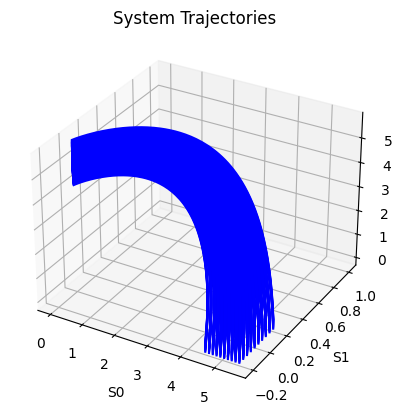

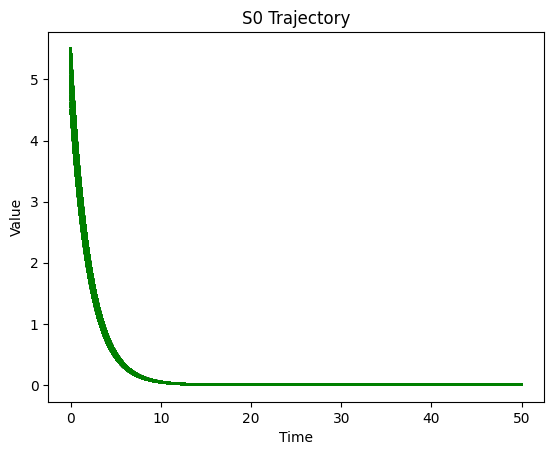

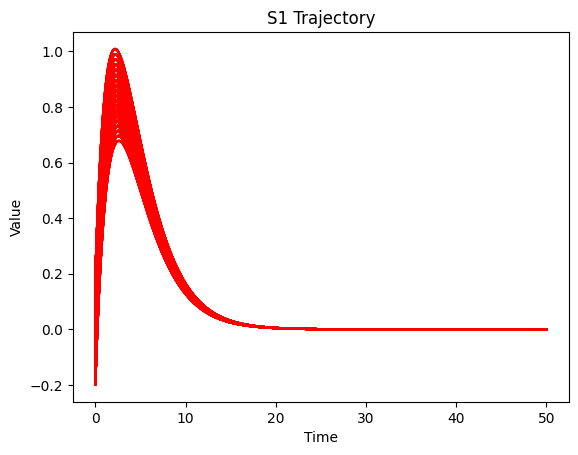

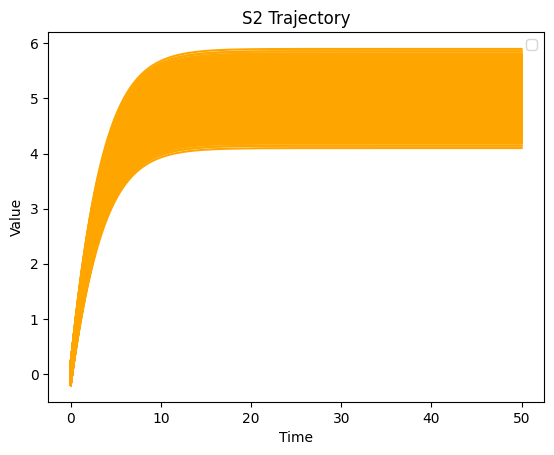

In [6]:
# Plot
ax = plt.figure().add_subplot(projection='3d')
ax2 = plt.figure().add_subplot()
ax3 = plt.figure().add_subplot()
ax4 = plt.figure().add_subplot()

def add_trajectory(val, dt=0.1, steps=500):
    res = integration(val, dt, steps)
    ax.plot([row[0] for row in res[:,2]], [row[1] for row in res[:,2]], [row[2] for row in res[:,2]], color="blue")#Runge Kutta plot
    ax2.plot(res[:,0], [row[0] for row in res[:,2]], color="green")
    ax3.plot(res[:,0], [row[1] for row in res[:,2]], color="red")
    ax4.plot(res[:,0], [row[2] for row in res[:,2]], color="orange")

for i in np.linspace(-0.5,0.5,10):
    for j in np.linspace(-0.2,0.2,10):
        for w in np.linspace(-0.2,0.2,10):
            add_trajectory(val_0+np.array([i,j,w]))

#collect data from the trajectories for training/testing
data_map_in = np.array(data_map_in, dtype = object)
data_map_out = np.array(data_map_out, dtype = object)
data_dif_in = np.array(data_dif_in, dtype = object)
data_dif_out = np.array(data_dif_out, dtype = object)

plt.rcParams["figure.autolayout"] = True
leg = plt.legend(loc='upper right')
# Set axes labels
ax.set_xlabel("S0")
ax.set_ylabel("S1")
ax.set_zlabel("S2")
ax.set_title("System Trajectories")

ax2.set_xlabel("Time")
ax2.set_ylabel("Value")
ax2.set_title("S0 Trajectory")

ax3.set_xlabel("Time")
ax3.set_ylabel("Value")
ax3.set_title("S1 Trajectory")

ax4.set_xlabel("Time")
ax4.set_ylabel("Value")
ax4.set_title("S2 Trajectory")

plt.show()

### Making training and test data

In [7]:
#separating training from testing data and features from labels
data_map_pdin = pd.DataFrame(data_map_in.tolist(), columns = ["S0","S1","S2"])
data_map_pdout = pd.DataFrame(data_map_out.tolist(), columns = ["nS0","nS1","nS2"])#n means new
data_map_pd = pd.concat([data_map_pdin,data_map_pdout],axis=1)
data_dif_pdin = pd.DataFrame(data_dif_in.tolist(), columns = ["S0","S1","S2"])
data_dif_pdout = pd.DataFrame(data_dif_out.tolist(), columns = ["dotS0","dotS1","dotS2"])
data_dif_pd = pd.concat([data_dif_pdin,data_dif_pdout],axis=1)

train_map = data_map_pd.sample(frac=0.8, random_state=0)
test_map = data_map_pd.drop(train_map.index)

train_dif = data_dif_pd.sample(frac=0.8, random_state=0)
test_dif = data_dif_pd.drop(train_dif.index)

train_map_features = np.asarray(train_map[["S0","S1","S2"]].copy())
train_map_labels = np.asarray(train_map[["nS0","nS1","nS2"]].copy())
test_map_features = np.asarray(test_map[["S0","S1","S2"]].copy())
test_map_labels = np.asarray(test_map[["nS0","nS1","nS2"]].copy())

train_dif_features = train_dif[["S0","S1","S2"]].copy()
train_dif_labels = train_dif[["dotS0","dotS1","dotS2"]].copy()
test_dif_features = test_dif[["S0","S1","S2"]].copy()
test_dif_labels = test_dif[["dotS0","dotS1","dotS2"]].copy()

### Building and training the time-1 map model

In [14]:
normalizer_map = layers.Normalization(axis=-1)
normalizer_map.adapt(np.array(train_map_features))
model_map = keras.Sequential(
    [
        normalizer_map,
        layers.Dense(15, activation="relu"),
        layers.Dense(15, activation="relu"),
        layers.Dense(3)
    ]
)
model_map.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
model_map.summary()

history_map = model_map.fit(
    train_map_features,
    train_map_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

model_map.save("model_map.tf", save_format="tf")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 3)                 7         
 on)                                                             
                                                                 
 dense (Dense)               (None, 15)                60        
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 dense_2 (Dense)             (None, 3)                 48        
                                                                 
Total params: 355 (1.39 KB)
Trainable params: 348 (1.36 KB)
Non-trainable params: 7 (32.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model_map.tf/assets


INFO:tensorflow:Assets written to: model_map.tf/assets


### Evaluating the model

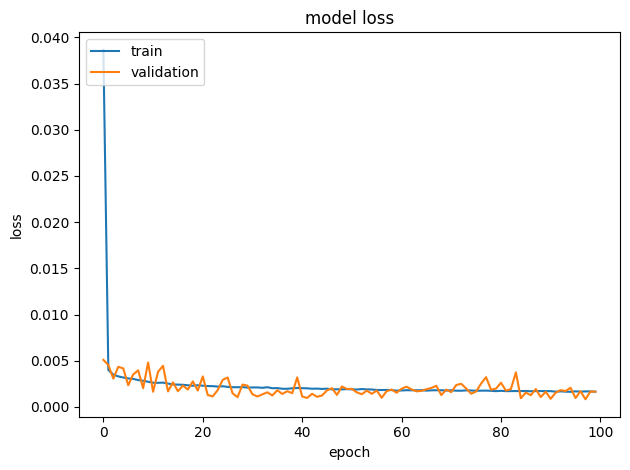

Evaluate on training data
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0017
training loss: 0.001657055807299912
Evaluate on test data
782/782 [==============================] - 1s 1ms/step - loss: 0.0016
test loss: 0.0016471188282594085


In [15]:
# Loss
plt.plot(history_map.history['loss'])
plt.plot(history_map.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Evaluate the model on the test data using `evaluate`
print("Evaluate on training data")
results = model_map.evaluate(train_map_features, train_map_labels, batch_size=128)
print("training loss:", results)
print("Evaluate on test data")
results = model_map.evaluate(test_map_features, test_map_labels, batch_size=128)
print("test loss:", results)

1/1 [==============================] - 0s 17ms/step


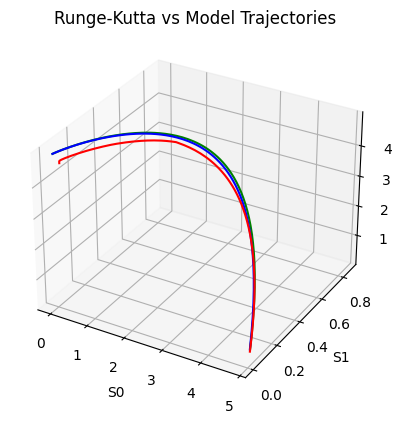

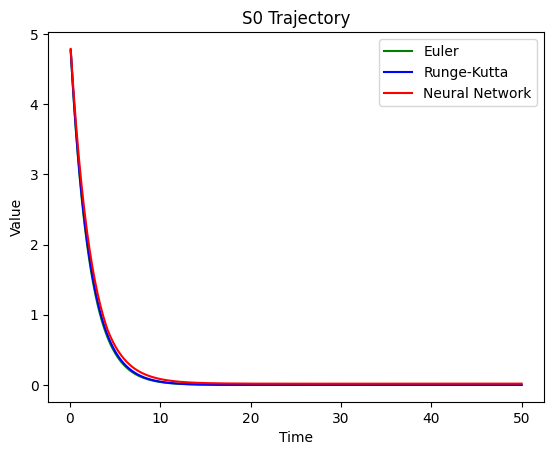

In [5]:
model_map = keras.models.load_model("model_map.tf")
res_ar = []
val_model = val_rk = val_euler = val_0
time = 0.0
dt = 0.1
steps = 500
for i in range(steps):
    val_rk = f_rk(val_rk, dt)
    val_model = model_map.predict(val_model)[0]
    val_euler = f_euler(val_euler, dt)
    time += dt
    res_ar.append([time, val_model, val_rk, val_euler])
res_ar = np.array(res_ar, dtype = object)
ax5 = plt.figure().add_subplot(projection='3d')
ax6 = plt.figure().add_subplot()
ax5.plot([row[0] for row in res_ar[:,3]], [row[1] for row in res_ar[:,3]], [row[2] for row in res_ar[:,3]], color="green", label="Euler")#Euler plot
ax5.plot([row[0] for row in res_ar[:,2]], [row[1] for row in res_ar[:,2]], [row[2] for row in res_ar[:,2]], color="blue", label="Runge Kutta")#Runge Kutta plot
ax5.plot([row[0] for row in res_ar[:,1]], [row[1] for row in res_ar[:,1]], [row[2] for row in res_ar[:,1]], color="red", label="Model Predicted")#Model predicted plot
ax6.plot(res_ar[:,0], [row[0] for row in res_ar[:,3]], color="green", label="Euler")
ax6.plot(res_ar[:,0], [row[0] for row in res_ar[:,2]], color="blue", label="Runge-Kutta")
ax6.plot(res_ar[:,0], [row[0] for row in res_ar[:,1]], color="red", label="Neural Network")

plt.rcParams["figure.autolayout"] = True
leg = plt.legend(loc='upper right')
# Set axes labels
ax5.set_xlabel("S0")
ax5.set_ylabel("S1")
ax5.set_zlabel("S2")
ax5.set_title("Runge-Kutta vs Model Trajectories")

ax6.set_xlabel("Time")
ax6.set_ylabel("Value")
ax6.set_title("S0 Trajectory")
plt.show()

### Building and training the differential equation model

In [8]:
normalizer_dif = layers.Normalization(axis=-1)
normalizer_dif.adapt(np.array(train_dif_features))
model_dif = keras.Sequential(
    [
        normalizer_dif,
        layers.Dense(15, activation="relu"),
        layers.Dense(15, activation="relu"),
        layers.Dense(3)
    ]
)
model_dif.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
model_dif.summary()

history_dif = model_dif.fit(
    train_dif_features,
    train_dif_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

model_dif.save("model_dif.tf", save_format="tf")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 3)                 7         
 on)                                                             
                                                                 
 dense (Dense)               (None, 15)                60        
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 dense_2 (Dense)             (None, 3)                 48        
                                                                 
Total params: 355 (1.39 KB)
Trainable params: 348 (1.36 KB)
Non-trainable params: 7 (32.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model_dif.tf/assets


INFO:tensorflow:Assets written to: model_dif.tf/assets


### Evaluating the model

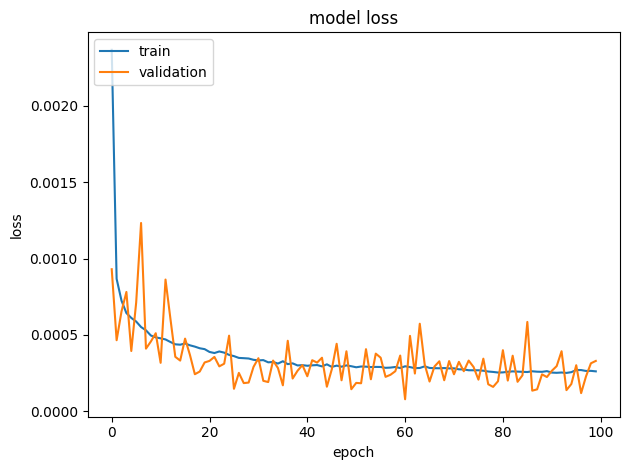

Evaluate on training data
3125/3125 [==============================] - 4s 1ms/step - loss: 3.2989e-04
training loss: 0.0003298925294075161
Evaluate on test data
782/782 [==============================] - 1s 1ms/step - loss: 3.2944e-04
test loss: 0.0003294444177299738


In [9]:
# Loss
plt.plot(history_dif.history['loss'])
plt.plot(history_dif.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Evaluate the model on the test data using `evaluate`
print("Evaluate on training data")
results = model_dif.evaluate(train_dif_features, train_dif_labels, batch_size=128)
print("training loss:", results)
print("Evaluate on test data")
results = model_dif.evaluate(test_dif_features, test_dif_labels, batch_size=128)
print("test loss:", results)

1/1 [==============================] - 0s 16ms/step


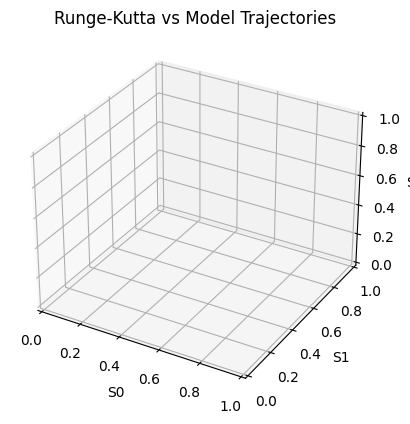

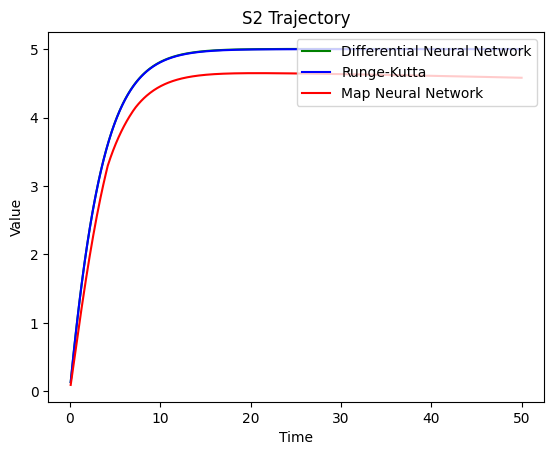

In [5]:
model_dif = keras.models.load_model("model_dif.tf")
model_map = keras.models.load_model("model_map.tf")
res_ar = []
val_map = val_rk = val_dif = val_0
time = 0.0
dt = 0.1
steps = 500

def f2(val):#based on the NN
    return model_dif.predict(val)[0]

def f_rk2(val, dt):
    k_1 = f2(val)*dt
    k_2 = f2(val + 0.5*k_1)*dt
    k_3 = f2(val + 0.5*k_2)*dt
    k_4 = f2(val + k_3)*dt
    nval = val + (1/6)*(k_1 + 2*k_2 + 2*k_3 + k_4)
    return nval

for i in range(steps):
    val_rk = f_rk(val_rk, dt)
    val_map = model_map.predict(val_map)[0]
    val_dif = f_rk2(val_dif, dt)
    time += dt
    res_ar.append([time, val_map, val_rk, val_dif])
res_ar = np.array(res_ar, dtype = object)
ax5 = plt.figure().add_subplot(projection='3d')
ax6 = plt.figure().add_subplot()
#ax5.plot([row[0] for row in res_ar[:,3]], [row[1] for row in res_ar[:,3]], [row[2] for row in res_ar[:,3]], color="green", label="Differential Neural Network")#Dif NN plot
#ax5.plot([row[0] for row in res_ar[:,2]], [row[1] for row in res_ar[:,2]], [row[2] for row in res_ar[:,2]], color="blue", label="Runge Kutta")#Runge Kutta plot
#ax5.plot([row[0] for row in res_ar[:,1]], [row[1] for row in res_ar[:,1]], [row[2] for row in res_ar[:,1]], color="red", label="Model Predicted")#Map NN plot
ax6.plot(res_ar[:,0], [row[2] for row in res_ar[:,3]], color="green", label="Differential Neural Network")
ax6.plot(res_ar[:,0], [row[2] for row in res_ar[:,2]], color="blue", label="Runge-Kutta")
ax6.plot(res_ar[:,0], [row[2] for row in res_ar[:,1]], color="red", label="Map Neural Network")

plt.rcParams["figure.autolayout"] = True
leg = plt.legend(loc='upper right')
# Set axes labels
ax5.set_xlabel("S0")
ax5.set_ylabel("S1")
ax5.set_zlabel("S2")
ax5.set_title("Runge-Kutta vs Model Trajectories")

ax6.set_xlabel("Time")
ax6.set_ylabel("Value")
ax6.set_title("S2 Trajectory")
plt.show()